## Exploring noise with Fourier

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftn, ifftn
import scipy.interpolate 
import cv2
import time
import itertools
import ot
import glob
import os
from utils.utils import *

In [5]:
dotmark_pictures_path = "..\\DOTmark_1.0\\Pictures\\"
full_path = os.path.join(os.getcwd(), dotmark_pictures_path)
resolution = 32
image_numbers = ['01','02','03','04','05','06','07','08','09','10']
pairs = list(itertools.combinations(image_numbers, 2))

categories_pattern = os.path.join(dotmark_pictures_path, "*")
category_dirs = glob.glob(categories_pattern)
category_names = [os.path.basename(category) for category in category_dirs if os.path.isdir(category)]

In [6]:

def Fourier1(a, b, T=2 * np.pi):
    pipi = 2 * np.pi
    m, n = np.shape(a)
    dxdy = (T / m) * (T / n)

    # Normalize a and b
    a /= np.sum(a)
    b /= np.sum(b)

    # Perform FFT
    fa = np.fft.fft2(a)
    fb = np.fft.fft2(b)

    # Calculate distance using a single loop
    integrale = 0
    for y in range(n):
        for x in range(m):
            # Compute frequency magnitude (handling the zero frequency separately)
            if x == 0 and y == 0:
                continue  # Skip the zero frequency to avoid division by zero
            freq_magnitude = np.sqrt(((x * pipi / m) ** 2) + ((y * pipi / n) ** 2))
            
            # Increment integral
            integrale += ((np.abs(fa[x, y] - fb[x, y])) ** 2) / (freq_magnitude ** 2) * dxdy

    # Calculate final distance
    C = (((1 / T) ** 2) * 2 * integrale) ** (1 / 2)
    return C

In [7]:
def calculate_costs(size, distance_metric='L1'):
    """
    This function of an array or image and calculates the cost from it to itself.

    Parameters:
    - `size` (int or tuple): representing the object on which we would like to calculate costs.

    Returns:
    - `costs` (numpy.ndarray): A 2D array representing the matrix of costs of transporting pixels
                                from the first image to the second image.
    """

    # Helper function for L1 and L2 distance
    if distance_metric == 'L1':
        dist = lambda a, b: abs(a - b)
    elif distance_metric == 'L2':
        dist = lambda a, b: (a - b) ** 2
    else:
        raise ValueError('Invalid distance metric. Must be either "L1" or "L2".')

    # 1D case:
    if isinstance(size, int):
        X = np.linspace(0, 1, size)
        costs = np.zeros([size, size], np.float64)

        for it1 in range(size):
            for it2 in range(size):
                costs[it1, it2] = dist(X[it1], X[it2])

        return costs

    # 2D case:
    elif len(size) == 2:
        I, J = np.indices(size)
        
        # Flatten the indices to create 1D arrays of x and y coordinates
        I_flat = I.flatten()
        J_flat = J.flatten()
        
        # Calculate distances using broadcasting
        if distance_metric == 'L1':
            costs = np.abs(I_flat[:, None] - I_flat[None, :]) + np.abs(J_flat[:, None] - J_flat[None, :])
        elif distance_metric == 'L2':
            costs = np.sqrt((I_flat[:, None] - I_flat[None, :]) ** 2 + (J_flat[:, None] - J_flat[None, :]) ** 2)
        else:
            raise ValueError('Invalid distance metric. Must be either "L1" or "L2".')

        return costs

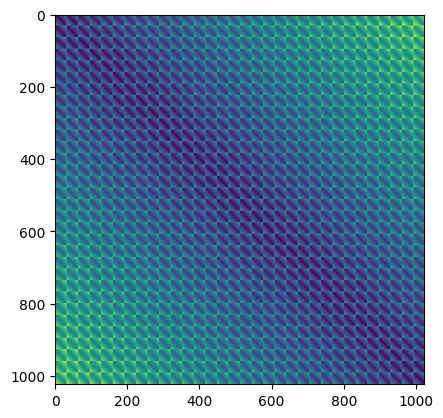

In [8]:
cost_matrix_l1 = calculate_costs((32,32), distance_metric = 'L1')
plt.imshow(cost_matrix_l1, cmap='viridis')

In [9]:
pfm_values_normal = []
pfm_values_simplified = []
w_values = []

for category in category_names:
    category_dir = os.path.join(full_path, category)
    start = time.time()
    for image_pair in pairs:
        # Loading and normalizing images
        path_im1 = os.path.join(category_dir, f"picture{resolution}_10{image_pair[0]}.png")
        im1 = cv2.imread(path_im1, cv2.IMREAD_GRAYSCALE)
        im1 = cv2.resize(im1, (resolution, resolution))
        im1 = im1 / im1.sum()  # Normalize
        path_im2 = os.path.join(category_dir, f"picture{resolution}_10{image_pair[1]}.png")
        im2 = cv2.imread(path_im2, cv2.IMREAD_GRAYSCALE)
        im2 = cv2.resize(im2, (resolution, resolution))
        im2 = im2 / im2.sum()  # Normalize
        
        pfm = Fourier1(im1, im2)
        pfm_values_normal.append(pfm)

        #Calculate the EMD
        # cost_matrix = calculate_costs(im1.shape, distance_metric = 'L1')
        w_dist = ot.emd2(im1.flatten(), im2.flatten(), cost_matrix_l1)
        w_values.append(w_dist)
    
    end = time.time()
    print(f'{end - start} Time elapsed for Category {category}')

2.8749852180480957 Time elapsed for Category CauchyDensity
5.083874225616455 Time elapsed for Category ClassicImages
3.987016201019287 Time elapsed for Category GRFmoderate
5.091838359832764 Time elapsed for Category GRFrough
3.899799346923828 Time elapsed for Category GRFsmooth
3.409801483154297 Time elapsed for Category LogGRF
4.071277379989624 Time elapsed for Category LogitGRF
2.3062853813171387 Time elapsed for Category MicroscopyImages
1.5238642692565918 Time elapsed for Category Shapes
10.079981565475464 Time elapsed for Category WhiteNoise


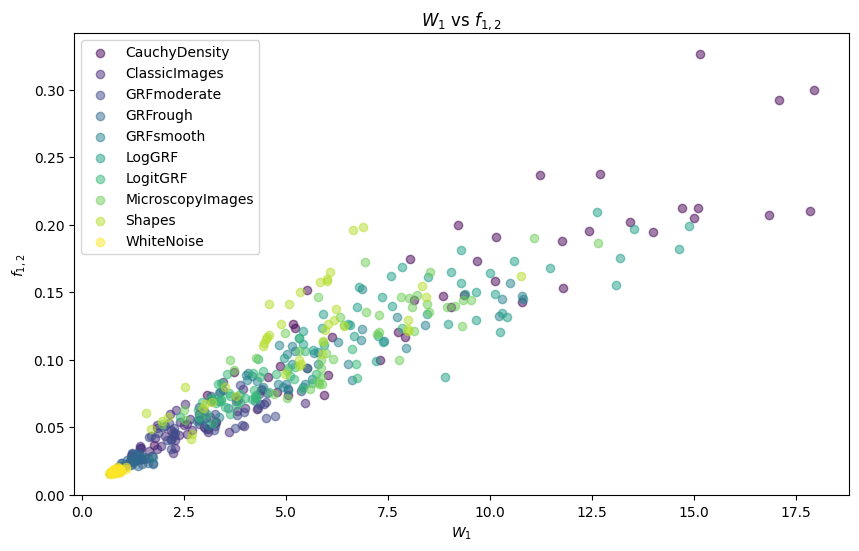

In [10]:
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 10))  # 10 distinct colors
for i in range(10):  # 10 groups of 45 samples each
    start = i * 45
    end = (i + 1) * 45
    plt.scatter(w_values[start:end], pfm_values_normal[start:end], color=colors[i], alpha=0.5, label=f'{category_names[i]}')
plt.title('$W_1$ vs $f_{1,2}$')
plt.xlabel('$W_1$')
plt.ylabel('$f_{1,2}$')
plt.legend()
plt.show()

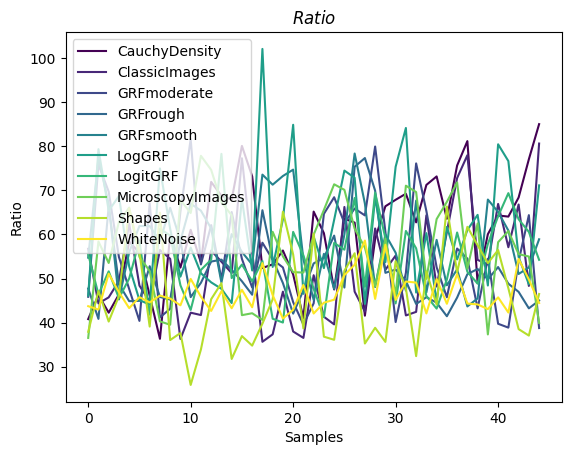

In [11]:
ratios = np.array(w_values) / np.array(pfm_values_normal)
for i in range(10):
    start = i * 45
    end = (i + 1) * 45
    plt.plot(ratios[start:end], color=colors[i], label=f'{category_names[i]}')

plt.xlabel('Samples')
plt.ylabel('Ratio')
plt.legend()
plt.title('$Ratio$')
plt.show()